# Exercise 3: Preparing Real-World Data for a Neural Network

Use the Spaceship Titanic dataset from Kaggle to practice data preprocessing for neural networks.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

## Load and Explore the Dataset

First, download the Spaceship Titanic dataset from Kaggle and place it in the data folder.

In [18]:
# Load the dataset
df = pd.read_csv('../data/train.csv')
print("Dataset loaded successfully!")

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nDataset objective: Predict if a passenger was transported to another dimension")

Dataset loaded successfully!

Dataset shape: (8693, 14)

Column names: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Dataset objective: Predict if a passenger was transported to another dimension


In [19]:
# Explore the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['Transported'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

First 5 rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B

In [20]:
print(f"\nTarget Distribution:")
transported_counts = df['Transported'].value_counts()
print(f"  Transported: {transported_counts.get(True, 0)} ({transported_counts.get(True, 0)/len(df)*100:.1f}%)")
print(f"  Not Transported: {transported_counts.get(False, 0)} ({transported_counts.get(False, 0)/len(df)*100:.1f}%)")

# Identify feature types
numerical_features = []
categorical_features = []

for col in df.columns:
    if col in ['PassengerId', 'Name', 'Transported']:
        continue
    elif col == 'Cabin':
        continue  # We'll handle this separately
    elif df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    else:
        categorical_features.append(col)

print(f"\nFeature Classification:")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Target Distribution:
  Transported: 4378 (50.4%)
  Not Transported: 4315 (49.6%)

Feature Classification:
Numerical features (6): ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical features (4): ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


In [21]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if len(missing_data) > 0:
    print("Columns with missing values:")
    for col, count in missing_data.items():
        percentage = (count / len(df)) * 100
        print(f"  {col}: {count} ({percentage:.1f}%)")
else:
    print("No missing values found.")

Columns with missing values:
  CryoSleep: 217 (2.5%)
  ShoppingMall: 208 (2.4%)
  VIP: 203 (2.3%)
  HomePlanet: 201 (2.3%)
  Name: 200 (2.3%)
  Cabin: 199 (2.3%)
  VRDeck: 188 (2.2%)
  FoodCourt: 183 (2.1%)
  Spa: 183 (2.1%)
  Destination: 182 (2.1%)
  RoomService: 181 (2.1%)
  Age: 179 (2.1%)


## Data Preprocessing for Neural Network

In [30]:
df_processed = df.copy()

# Extract features from Cabin
if 'Cabin' in df_processed.columns:
    cabin_split = df_processed['Cabin'].str.split('/', expand=True)
    df_processed['Deck'] = cabin_split[0]
    df_processed['Cabin_Num'] = pd.to_numeric(cabin_split[1], errors='coerce')
    df_processed['Side'] = cabin_split[2]
    
    # Add these to our feature lists
    categorical_features.extend(['Deck', 'Side'])
    numerical_features.append('Cabin_Num')
    

# Drop unnecessary columns
df_processed = df_processed.drop(['PassengerId', 'Name', 'Cabin'], axis=1, errors='ignore')

print("I dropped 'Cabin' because I extracted useful information from it and created new features.")
print("I dropped 'PassengerId' and 'Name' because they are identifiers and do not provide predictive value.")

I dropped 'Cabin' because I extracted useful information from it and created new features.
I dropped 'PassengerId' and 'Name' because they are identifiers and do not provide predictive value.


In [31]:
missing_strategies = {
    'numerical': 'median',
    'categorical': 'most_frequent'
}

print(f"Strategy: Fill numerical features with {missing_strategies['numerical']} to avoid impacting the data.")
print(f"Strategy: Fill categorical features with {missing_strategies['categorical']} to avoid introducing new categories.")

# Handle numerical missing values
for col in numerical_features:
    if col in df_processed.columns and df_processed[col].isnull().sum() > 0:
        if missing_strategies['numerical'] == 'median':
            fill_value = df_processed[col].median()
        else:
            fill_value = df_processed[col].mean()
        df_processed[col] = df_processed[col].fillna(fill_value)
        print(f"   {col}: filled {df_processed[col].isnull().sum()} missing values with {fill_value:.2f}")

# Handle categorical missing values
for col in categorical_features:
    if col in df_processed.columns and df_processed[col].isnull().sum() > 0:
        if missing_strategies['categorical'] == 'most_frequent':
            fill_value = df_processed[col].mode().iloc[0] if len(df_processed[col].mode()) > 0 else 'Unknown'
        else:
            fill_value = 'Unknown'
        df_processed[col] = df_processed[col].fillna(fill_value)
        print(f"   {col}: filled missing values with '{fill_value}'")

# Handle boolean columns (VIP, CryoSleep)
boolean_cols = ['VIP', 'CryoSleep']
for col in boolean_cols:
    if col in df_processed.columns:
        # Convert to binary and fill missing with most frequent
        df_processed[col] = df_processed[col].astype('boolean')
        if df_processed[col].isnull().sum() > 0:
            fill_value = df_processed[col].mode().iloc[0] if len(df_processed[col].mode()) > 0 else False
            df_processed[col] = df_processed[col].fillna(fill_value)
            print(f"   {col}: filled missing values with {fill_value}")



Strategy: Fill numerical features with median to avoid impacting the data.
Strategy: Fill categorical features with most_frequent to avoid introducing new categories.
   Age: filled 0 missing values with 27.00
   RoomService: filled 0 missing values with 0.00
   FoodCourt: filled 0 missing values with 0.00
   ShoppingMall: filled 0 missing values with 0.00
   Spa: filled 0 missing values with 0.00
   VRDeck: filled 0 missing values with 0.00
   Cabin_Num: filled 0 missing values with 427.00
   HomePlanet: filled missing values with 'Earth'
   CryoSleep: filled missing values with 'False'
   Destination: filled missing values with 'TRAPPIST-1e'
   VIP: filled missing values with 'False'
   Deck: filled missing values with 'F'
   Side: filled missing values with 'S'


/tmp/ipykernel_148434/551721061.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed[col] = df_processed[col].fillna(fill_value)


## Encoding

In [ ]:
# print(len(categorical_features))
# print(categorical_features)

8
['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Deck', 'Side']


In [35]:
# First, clean up categorical_features to remove duplicates and boolean columns
clean_categorical_features = []
for feature in categorical_features:
    if feature not in boolean_cols and feature not in clean_categorical_features:
        clean_categorical_features.append(feature)

print(f"Cleaned categorical features: {clean_categorical_features}")

# One-hot encode only the true categorical features
categorical_encoded = pd.get_dummies(df_processed[clean_categorical_features], prefix=clean_categorical_features, drop_first=True)
print(f"One-hot encoded {len(clean_categorical_features)} categorical features")
print(f"  Original categorical columns: {len(clean_categorical_features)}")
print(f"  Encoded categorical columns: {categorical_encoded.shape[1]}")

# Convert boolean columns to int
for col in boolean_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype(int)

Cleaned categorical features: ['HomePlanet', 'Destination', 'Deck', 'Side']
One-hot encoded 4 categorical features
  Original categorical columns: 4
  Encoded categorical columns: 12


In [36]:
feature_columns = []
feature_data = []

# Add numerical features
for col in numerical_features:
    if col in df_processed.columns:
        feature_columns.append(col)
        feature_data.append(df_processed[col].values.reshape(-1, 1))

# Add boolean features
for col in boolean_cols:
    if col in df_processed.columns:
        feature_columns.append(col)
        feature_data.append(df_processed[col].values.reshape(-1, 1))

# Add encoded categorical features
if categorical_encoded.shape[1] > 0:
    feature_columns.extend(categorical_encoded.columns.tolist())
    feature_data.append(categorical_encoded.values)

# Combine all features
if feature_data:
    X = np.hstack(feature_data)
else:
    X = np.array([]).reshape(len(df_processed), 0)

y = df_processed['Transported'].astype(int).values

print(f"✓ Feature matrix created")
print(f"  Shape: {X.shape}")
print(f"  Features: {len(feature_columns)}")
print(f"  Target shape: {y.shape}")

✓ Feature matrix created
  Shape: (8693, 22)
  Features: 22
  Target shape: (8693,)


In [38]:
print("Since we're using tanh activation (range [-1, 1]), we'll use standardization.")
print("This centers features at 0 and scales to unit variance, which works well with tanh.")

# Manual standardization (alternative to StandardScaler)
def manual_standardization(X):
    """Manually standardize features"""
    X_standardized = np.zeros_like(X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    # Avoid division by zero for constant features
    stds = np.where(stds == 0, 1, stds)
    
    X_standardized = (X - means) / stds
    return X_standardized, means, stds

X_normalized, feature_means, feature_stds = manual_standardization(X)

print(f"Features normalized using standardization")
print(f"  Feature range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"  Feature mean: {X_normalized.mean():.3f}")
print(f"  Feature std: {X_normalized.std():.3f}")


Since we're using tanh activation (range [-1, 1]), we'll use standardization.
This centers features at 0 and scales to unit variance, which works well with tanh.
Features normalized using standardization
  Feature range: [-2.008, 41.685]
  Feature mean: -0.000
  Feature std: 1.000


It is a good practice to encode before feeding the data to a neural network to avoid issues with the outliers and big ranges that may exist in the data. This happens with for example with the `RoomNumber` feature, which can have values from 1 to 10000.

## Visualization
Visualize the distribution of numerical features before and after normalization.

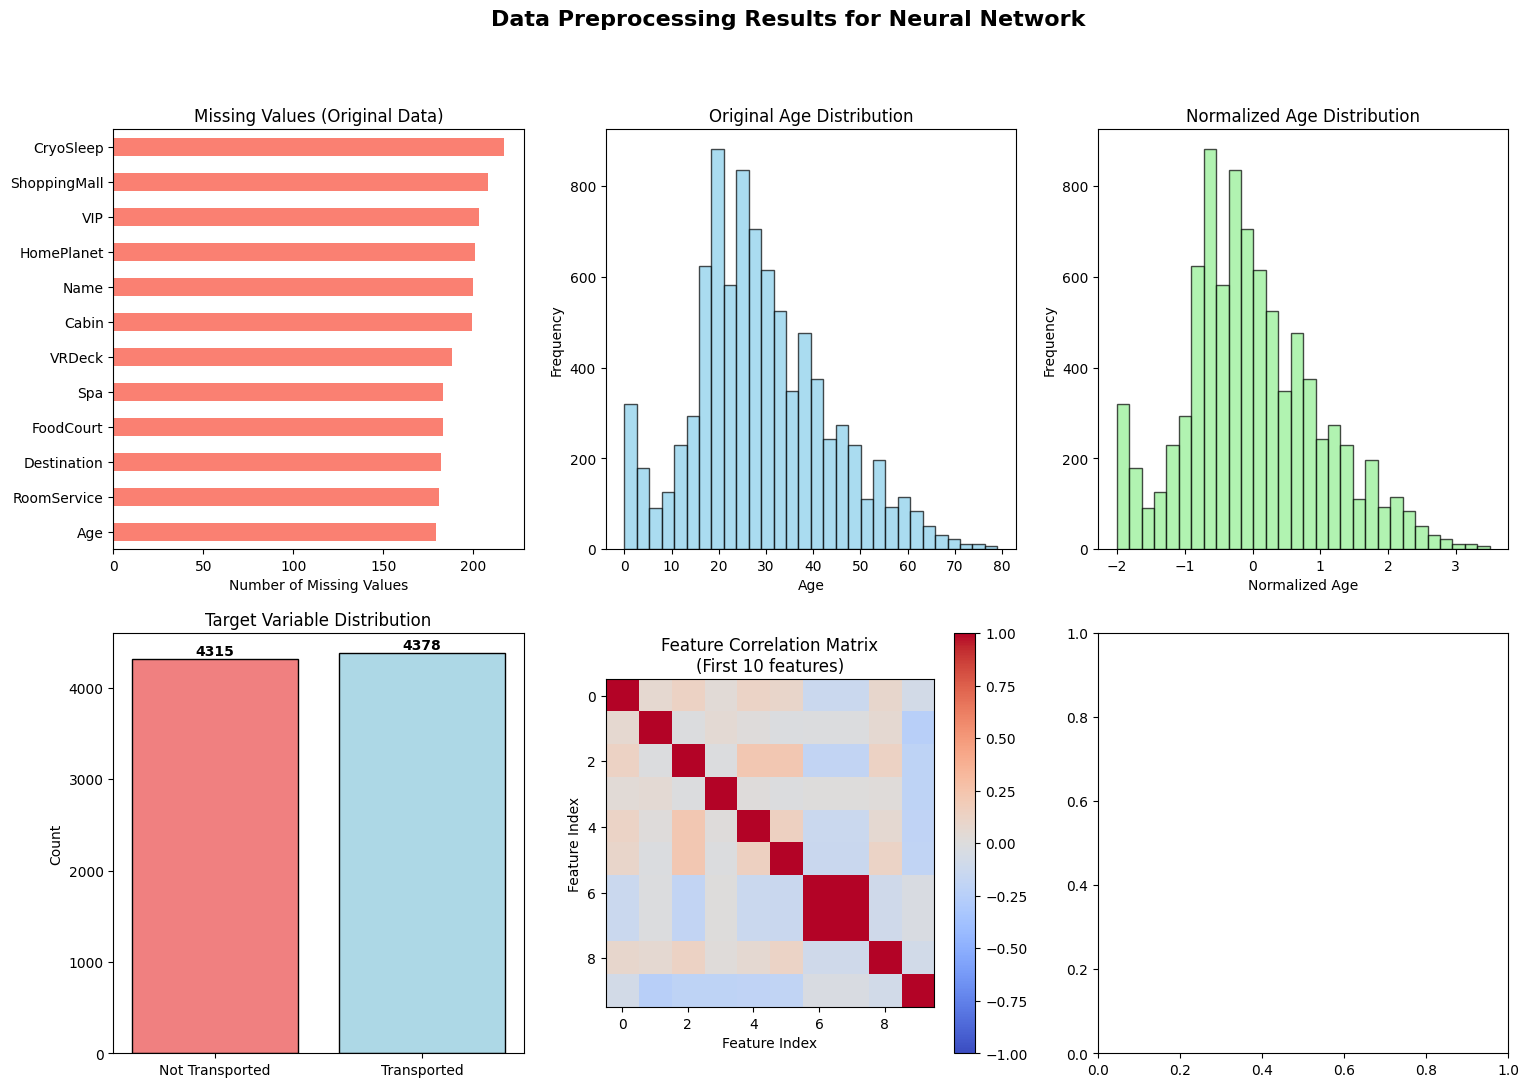

In [39]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Data Preprocessing Results for Neural Network', fontsize=16, fontweight='bold')

# Plot 1: Missing values before preprocessing
ax1 = axes[0, 0]
missing_original = df.isnull().sum()
missing_original = missing_original[missing_original > 0].sort_values(ascending=True)
if len(missing_original) > 0:
    missing_original.plot(kind='barh', ax=ax1, color='salmon')
    ax1.set_title('Missing Values (Original Data)')
    ax1.set_xlabel('Number of Missing Values')
else:
    ax1.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Missing Values (Original Data)')

# Plot 2: Feature distribution before normalization
ax2 = axes[0, 1]
if len(numerical_features) > 0:
    sample_feature = numerical_features[0]
    if sample_feature in df_processed.columns:
        original_feature_idx = feature_columns.index(sample_feature)
        ax2.hist(X[:, original_feature_idx], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_title(f'Original {sample_feature} Distribution')
        ax2.set_xlabel(sample_feature)
        ax2.set_ylabel('Frequency')

# Plot 3: Feature distribution after normalization
ax3 = axes[0, 2]
if len(numerical_features) > 0:
    sample_feature = numerical_features[0]
    if sample_feature in feature_columns:
        original_feature_idx = feature_columns.index(sample_feature)
        ax3.hist(X_normalized[:, original_feature_idx], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        ax3.set_title(f'Normalized {sample_feature} Distribution')
        ax3.set_xlabel(f'Normalized {sample_feature}')
        ax3.set_ylabel('Frequency')

# Plot 4: Target distribution
ax4 = axes[1, 0]
target_counts = pd.Series(y).value_counts().sort_index()
colors = ['lightcoral', 'lightblue']
bars = ax4.bar(['Not Transported', 'Transported'], target_counts.values, color=colors, edgecolor='black')
ax4.set_title('Target Variable Distribution')
ax4.set_ylabel('Count')
# Add value labels on bars
for bar, count in zip(bars, target_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 5: Feature correlation (first 10 features)
ax5 = axes[1, 1]
n_features_to_show = min(10, X_normalized.shape[1])
if n_features_to_show > 1:
    corr_matrix = np.corrcoef(X_normalized[:, :n_features_to_show].T)
    im = ax5.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax5.set_title(f'Feature Correlation Matrix\n(First {n_features_to_show} features)')
    ax5.set_xlabel('Feature Index')
    ax5.set_ylabel('Feature Index')
    plt.colorbar(im, ax=ax5)

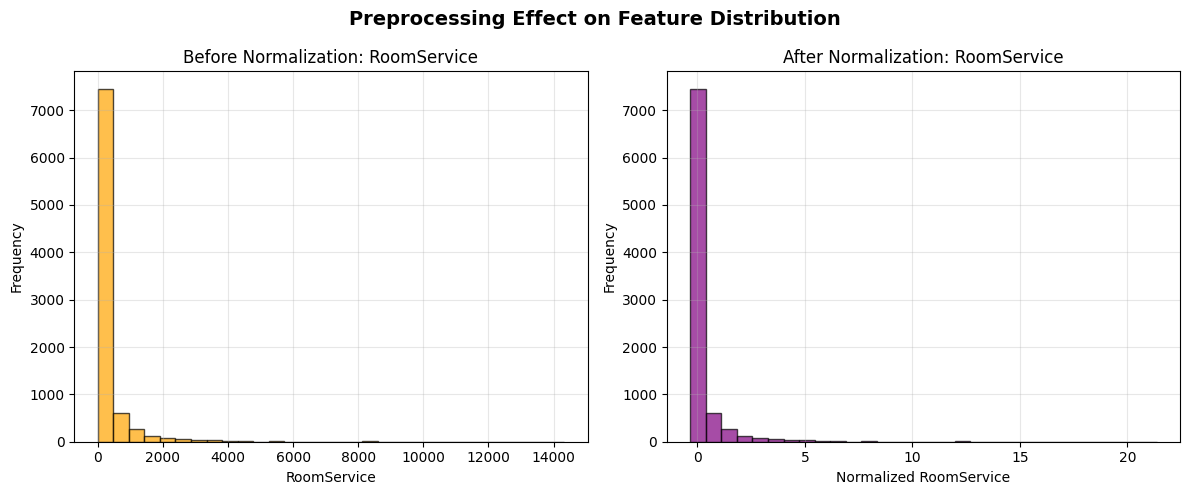

In [40]:
if len(numerical_features) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sample_feature_2 = numerical_features[1] if len(numerical_features) > 1 else numerical_features[0]
    if sample_feature_2 in feature_columns:
        feature_idx = feature_columns.index(sample_feature_2)
        
        # Before normalization
        ax1.hist(X[:, feature_idx], bins=30, alpha=0.7, color='orange', edgecolor='black')
        ax1.set_title(f'Before Normalization: {sample_feature_2}')
        ax1.set_xlabel(sample_feature_2)
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
        
        # After normalization
        ax2.hist(X_normalized[:, feature_idx], bins=30, alpha=0.7, color='purple', edgecolor='black')
        ax2.set_title(f'After Normalization: {sample_feature_2}')
        ax2.set_xlabel(f'Normalized {sample_feature_2}')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Preprocessing Effect on Feature Distribution', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
